# Setup

In [17]:
from collections import defaultdict
import json
import os

import numpy as np
import pandas as pd

import networkx as nx
from collections import defaultdict
from collections import deque
import matplotlib.pyplot as plt

In [18]:
FILE_PATH = '../../Data/comments_graph.json'

# Comment Tree

In [19]:
def organize_comments(comments_data):

    tree = defaultdict(list)
    
    for comment in comments_data:

        # skip deleted ones
        if comment['user'] == "Deleted" or comment['message'] == "[deleted]":
            continue
        
        parent_id = comment['parent_id']
        if parent_id:
            tree[parent_id].append(comment)
        else:
            tree[None].append(comment)
    
    return tree

def create_tree(comment, tree):

    node = {
            'comment_id': comment['comment_id'],
            'user': comment['user'],
            'timestamp': comment['time'],
            'message': comment['message'],
            'children': []
            }
    
    node['children'] = [create_tree(child, tree) for child in tree[comment['comment_id']]]
    return node

def build_comment_trees(file_path):

    with open(file_path, 'r') as file:
        comments_data = json.load(file)

    tree = organize_comments(comments_data)
    comment_trees = [create_tree(root_comment, tree) for root_comment in tree[None]]
    
    return comment_trees

In [20]:
comment_trees = build_comment_trees(FILE_PATH)

# Interaction Graph

In [21]:
def get_interactions(comment, G):

    stack = deque([comment]) 
    
    while stack:
        current_comment = stack.pop()
        current_user = current_comment['user']
        
        for child in current_comment['children']:
            child_user = child['user']
            
            if current_user and child_user and current_user != child_user:
                G.add_edge(current_user, child_user)
            
            stack.append(child)

def build_interaction_graph(interactions):

    G = nx.Graph()
    for user, neighbors in interactions.items():
        for neighbor in neighbors:
            G.add_edge(user, neighbor)
    
    return G

def generate_interaction_graph(comment_trees):
    
    G = nx.Graph()
    for tree in comment_trees:
        get_interactions(tree, G)
    
    return G

In [22]:
G = generate_interaction_graph(comment_trees)

In [23]:
# adj matrix as a numpy array
adj_matrix_np = nx.to_numpy_array(G)

# adj matrix as a pandas df
adj_matrix_df = nx.to_pandas_adjacency(G)

In [24]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

average_degree = sum(dict(G.degree()).values()) / num_nodes

max_degree_node = max(dict(G.degree()), key=dict(G.degree()).get)
max_degree = G.degree(max_degree_node)

degree_distribution = [deg for _, deg in G.degree()]

print(f"Number of Nodes: {num_nodes}")
print(f"Number of Edges: {num_edges}")
print(f"Average Degree: {average_degree:.2f}")
print(f"Node with Max Degree: {max_degree_node} (Degree: {max_degree})")

Number of Nodes: 184
Number of Edges: 168
Average Degree: 1.83
Node with Max Degree: ClusterFoxtrot (Degree: 30)


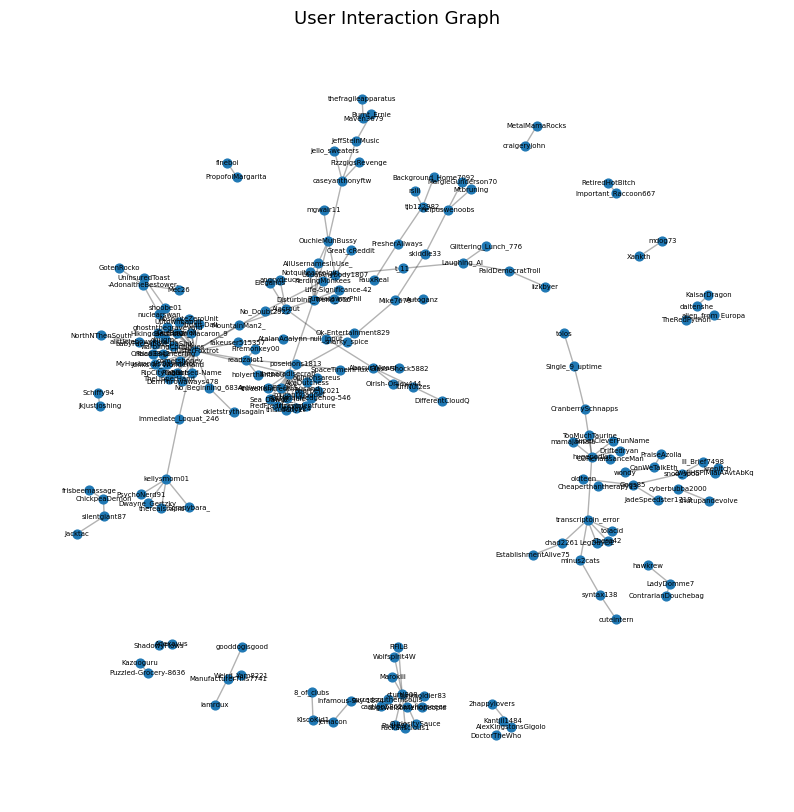

In [25]:
plt.figure(figsize=(10, 10))

pos = nx.spring_layout(G, k=0.2, seed=42, iterations=100)

nx.draw_networkx_nodes(G, pos, node_size=40) 
nx.draw_networkx_edges(G, pos, alpha=0.3) 

nx.draw_networkx_labels(G, pos, font_size=5, font_family="sans-serif")

# Display the plot
plt.title("User Interaction Graph", fontsize=13)
plt.axis("off") 
plt.show()